# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([-0.00491876, -0.20614984,  0.00763412,  0.28412407]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
3.0723096773251464 -2.610378594147575


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_targetQs(rewards):
    targetQs = np.zeros_like(rewards)
    discount = 0.99
    for Qidx in range(len(targetQs)):
        count = 0
        for idx in range(Qidx, len(rewards), 1):
            targetQs[Qidx] += (0.99**count)*rewards[idx]
            count += 1
    targetQs = (targetQs - np.mean(targetQs))/ np.std(targetQs)
    return targetQs

In [10]:
def model_loss(states, actions, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                                     labels=actions_labels))
    #print(neg_log_prob_actions.shape, targetQs.shape)
    loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
        
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(1000, 4) actions:(1000,)
2
1
0


In [14]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
env.reset()

array([-0.00299955,  0.01906061,  0.03476791,  0.0032101 ])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
state, reward, action

(array([-0.08067589, -0.58241431,  0.0266631 ,  0.86105667]), 1.0, 0)

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps/batches
        while True:
        #for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, reward])
            state = next_state
            total_reward += reward
            if done is True:
                episodes_total_reward.append(total_reward)
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        targetQs = model_targetQs(rewards=rewards)
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                 model.actions: actions, 
                                                                 model.targetQs: targetQs})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{}'.format(np.mean(episodes_total_reward)),
              'loss:{}'.format(loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        loss_list.append([ep, loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

Episode:0 meanR:10.0 loss:1.1920929132713809e-08
Episode:1 meanR:9.5 loss:0.0
Episode:2 meanR:9.0 loss:-1.4901161193847656e-08
Episode:3 meanR:9.5 loss:0.0
Episode:4 meanR:9.4 loss:-6.622738357719982e-09
Episode:5 meanR:9.333333333333334 loss:0.0
Episode:6 meanR:9.285714285714286 loss:-1.3245476715439963e-08
Episode:7 meanR:9.25 loss:1.3245476715439963e-08
Episode:8 meanR:9.333333333333334 loss:1.1920929132713809e-08
Episode:9 meanR:9.3 loss:0.0
Episode:10 meanR:9.363636363636363 loss:0.0
Episode:11 meanR:9.5 loss:0.0
Episode:12 meanR:9.538461538461538 loss:1.1920929132713809e-08
Episode:13 meanR:9.5 loss:1.3245476715439963e-08
Episode:14 meanR:9.533333333333333 loss:1.1920929132713809e-08
Episode:15 meanR:9.5625 loss:2.3841858265427618e-08
Episode:16 meanR:9.588235294117647 loss:0.0
Episode:17 meanR:9.5 loss:-7.450580596923828e-09
Episode:18 meanR:9.526315789473685 loss:1.1920929132713809e-08
Episode:19 meanR:9.5 loss:-1.3245476715439963e-08
Episode:20 meanR:9.428571428571429 loss:-1.

Episode:186 meanR:9.91 loss:0.0
Episode:187 meanR:9.91 loss:0.0
Episode:188 meanR:9.9 loss:1.3245476715439963e-08
Episode:189 meanR:9.88 loss:-1.3245476715439963e-08
Episode:190 meanR:9.88 loss:-1.3245476715439963e-08
Episode:191 meanR:9.89 loss:1.1920929132713809e-08
Episode:192 meanR:9.89 loss:2.3841858265427618e-08
Episode:193 meanR:9.48 loss:1.3245476715439963e-08
Episode:194 meanR:9.49 loss:0.0
Episode:195 meanR:9.49 loss:0.0
Episode:196 meanR:9.48 loss:-2.2351741790771484e-08
Episode:197 meanR:9.48 loss:1.1920929132713809e-08
Episode:198 meanR:9.48 loss:3.5762788286319847e-08
Episode:199 meanR:9.47 loss:-1.3245476715439963e-08
Episode:200 meanR:9.48 loss:1.1920929132713809e-08
Episode:201 meanR:9.49 loss:2.167441692790817e-08
Episode:202 meanR:9.48 loss:-1.4901161193847656e-08
Episode:203 meanR:9.5 loss:0.0
Episode:204 meanR:9.5 loss:0.0
Episode:205 meanR:9.48 loss:-7.450580596923828e-09
Episode:206 meanR:9.49 loss:0.0
Episode:207 meanR:9.41 loss:-2.2351741790771484e-08
Episode:2

Episode:374 meanR:16.63 loss:-6.622738357719982e-09
Episode:375 meanR:16.64 loss:0.0
Episode:376 meanR:17.15 loss:0.0
Episode:377 meanR:17.15 loss:0.0
Episode:378 meanR:17.15 loss:0.0
Episode:379 meanR:17.24 loss:1.2548346361995755e-08
Episode:380 meanR:17.24 loss:0.0
Episode:381 meanR:16.79 loss:1.1920929132713809e-08
Episode:382 meanR:16.79 loss:2.3841858265427618e-08
Episode:383 meanR:16.8 loss:0.0
Episode:384 meanR:16.79 loss:0.0
Episode:385 meanR:16.79 loss:0.0
Episode:386 meanR:16.79 loss:1.1920929132713809e-08
Episode:387 meanR:16.82 loss:0.0
Episode:388 meanR:16.81 loss:-1.3245476715439963e-08
Episode:389 meanR:16.82 loss:1.1920929132713809e-08
Episode:390 meanR:16.83 loss:1.1920929132713809e-08
Episode:391 meanR:16.82 loss:-2.2351741790771484e-08
Episode:392 meanR:16.82 loss:-6.622738357719982e-09
Episode:393 meanR:16.82 loss:6.622738357719982e-09
Episode:394 meanR:16.83 loss:-6.622738357719982e-09
Episode:395 meanR:16.83 loss:0.0
Episode:396 meanR:16.46 loss:6.622738357719982

Episode:558 meanR:9.58 loss:0.0
Episode:559 meanR:9.56 loss:-1.4901161193847656e-08
Episode:560 meanR:9.54 loss:-1.4901161193847656e-08
Episode:561 meanR:9.53 loss:-1.3245476715439963e-08
Episode:562 meanR:9.53 loss:1.1920929132713809e-08
Episode:563 meanR:9.53 loss:-1.3245476715439963e-08
Episode:564 meanR:9.52 loss:-1.3245476715439963e-08
Episode:565 meanR:9.51 loss:1.3245476715439963e-08
Episode:566 meanR:9.52 loss:0.0
Episode:567 meanR:9.52 loss:2.3841858265427618e-08
Episode:568 meanR:9.52 loss:1.1920929132713809e-08
Episode:569 meanR:9.52 loss:0.0
Episode:570 meanR:9.53 loss:1.1920929132713809e-08
Episode:571 meanR:9.52 loss:0.0
Episode:572 meanR:9.51 loss:0.0
Episode:573 meanR:9.51 loss:0.0
Episode:574 meanR:9.51 loss:1.1920929132713809e-08
Episode:575 meanR:9.49 loss:-1.4901161193847656e-08
Episode:576 meanR:9.49 loss:2.3841858265427618e-08
Episode:577 meanR:9.48 loss:-1.3245476715439963e-08
Episode:578 meanR:9.47 loss:0.0
Episode:579 meanR:9.45 loss:-1.4901161193847656e-08
Epi

Episode:756 meanR:9.46 loss:1.1920929132713809e-08
Episode:757 meanR:9.47 loss:1.1920929132713809e-08
Episode:758 meanR:9.49 loss:0.0
Episode:759 meanR:9.49 loss:2.3841858265427618e-08
Episode:760 meanR:9.5 loss:0.0
Episode:761 meanR:9.5 loss:1.1920929132713809e-08
Episode:762 meanR:9.49 loss:-7.450580596923828e-09
Episode:763 meanR:9.49 loss:1.1920929132713809e-08
Episode:764 meanR:9.5 loss:1.1920929132713809e-08
Episode:765 meanR:9.49 loss:-6.622738357719982e-09
Episode:766 meanR:9.49 loss:2.3841858265427618e-08
Episode:767 meanR:9.5 loss:0.0
Episode:768 meanR:9.5 loss:1.1920929132713809e-08
Episode:769 meanR:9.49 loss:-1.9868215517249155e-08
Episode:770 meanR:9.5 loss:1.1920929132713809e-08
Episode:771 meanR:9.5 loss:1.1920929132713809e-08
Episode:772 meanR:9.51 loss:2.3841858265427618e-08
Episode:773 meanR:9.51 loss:1.1920929132713809e-08
Episode:774 meanR:9.51 loss:2.3841858265427618e-08
Episode:775 meanR:9.53 loss:1.1920929132713809e-08
Episode:776 meanR:9.55 loss:1.1920929132713

Episode:961 meanR:9.46 loss:1.1920929132713809e-08
Episode:962 meanR:9.47 loss:1.1920929132713809e-08
Episode:963 meanR:9.48 loss:1.1920929132713809e-08
Episode:964 meanR:9.49 loss:-6.622738357719982e-09
Episode:965 meanR:9.5 loss:0.0
Episode:966 meanR:9.52 loss:0.0
Episode:967 meanR:9.52 loss:1.1920929132713809e-08
Episode:968 meanR:9.52 loss:1.1920929132713809e-08
Episode:969 meanR:9.53 loss:0.0
Episode:970 meanR:9.54 loss:0.0
Episode:971 meanR:9.55 loss:1.1920929132713809e-08
Episode:972 meanR:9.54 loss:0.0
Episode:973 meanR:9.54 loss:0.0
Episode:974 meanR:9.52 loss:-6.622738357719982e-09
Episode:975 meanR:9.54 loss:1.1920929132713809e-08
Episode:976 meanR:9.55 loss:2.3841858265427618e-08
Episode:977 meanR:9.53 loss:-6.622738357719982e-09
Episode:978 meanR:9.53 loss:1.1920929132713809e-08
Episode:979 meanR:9.54 loss:0.0
Episode:980 meanR:9.54 loss:1.1920929132713809e-08
Episode:981 meanR:9.53 loss:-1.3245476715439963e-08
Episode:982 meanR:9.54 loss:1.1920929132713809e-08
Episode:983

Episode:1155 meanR:9.63 loss:1.1920929132713809e-08
Episode:1156 meanR:9.63 loss:0.0
Episode:1157 meanR:9.63 loss:1.1920929132713809e-08
Episode:1158 meanR:9.63 loss:2.3841858265427618e-08
Episode:1159 meanR:9.62 loss:-6.622738357719982e-09
Episode:1160 meanR:9.63 loss:0.0
Episode:1161 meanR:9.63 loss:1.1920929132713809e-08
Episode:1162 meanR:9.64 loss:0.0
Episode:1163 meanR:9.64 loss:1.1920929132713809e-08
Episode:1164 meanR:9.63 loss:-6.622738357719982e-09
Episode:1165 meanR:9.64 loss:0.0
Episode:1166 meanR:9.65 loss:-6.622738357719982e-09
Episode:1167 meanR:9.63 loss:-6.622738357719982e-09
Episode:1168 meanR:9.64 loss:2.3841858265427618e-08
Episode:1169 meanR:9.65 loss:1.1920929132713809e-08
Episode:1170 meanR:9.64 loss:-7.450580596923828e-09
Episode:1171 meanR:9.64 loss:1.1920929132713809e-08
Episode:1172 meanR:9.65 loss:0.0
Episode:1173 meanR:9.66 loss:1.1920929132713809e-08
Episode:1174 meanR:9.67 loss:1.1920929132713809e-08
Episode:1175 meanR:9.67 loss:1.1920929132713809e-08
Epi

Episode:1365 meanR:9.63 loss:-1.3245476715439963e-08
Episode:1366 meanR:9.61 loss:-1.4901161193847656e-08
Episode:1367 meanR:9.61 loss:1.1920929132713809e-08
Episode:1368 meanR:9.61 loss:0.0
Episode:1369 meanR:9.6 loss:0.0
Episode:1370 meanR:9.59 loss:-6.622738357719982e-09
Episode:1371 meanR:9.57 loss:-1.1175870895385742e-08
Episode:1372 meanR:9.59 loss:2.3841858265427618e-08
Episode:1373 meanR:9.59 loss:0.0
Episode:1374 meanR:9.58 loss:0.0
Episode:1375 meanR:9.58 loss:1.1920929132713809e-08
Episode:1376 meanR:9.59 loss:1.1920929132713809e-08
Episode:1377 meanR:9.6 loss:0.0
Episode:1378 meanR:9.6 loss:0.0
Episode:1379 meanR:9.61 loss:1.1920929132713809e-08
Episode:1380 meanR:9.62 loss:0.0
Episode:1381 meanR:9.61 loss:0.0
Episode:1382 meanR:9.61 loss:-6.622738357719982e-09
Episode:1383 meanR:9.61 loss:0.0
Episode:1384 meanR:9.6 loss:6.622738357719982e-09
Episode:1385 meanR:9.59 loss:-6.622738357719982e-09
Episode:1386 meanR:9.58 loss:-3.725290298461914e-09
Episode:1387 meanR:9.57 loss:

Episode:1565 meanR:9.43 loss:0.0
Episode:1566 meanR:9.43 loss:1.1920929132713809e-08
Episode:1567 meanR:9.45 loss:1.1920929132713809e-08
Episode:1568 meanR:9.45 loss:-6.622738357719982e-09
Episode:1569 meanR:9.45 loss:-6.622738357719982e-09
Episode:1570 meanR:9.45 loss:1.1920929132713809e-08
Episode:1571 meanR:9.45 loss:-6.622738357719982e-09
Episode:1572 meanR:9.44 loss:-6.622738357719982e-09
Episode:1573 meanR:9.46 loss:1.1920929132713809e-08
Episode:1574 meanR:9.45 loss:-6.622738357719982e-09
Episode:1575 meanR:9.44 loss:-6.622738357719982e-09
Episode:1576 meanR:9.45 loss:-6.622738357719982e-09
Episode:1577 meanR:9.45 loss:0.0
Episode:1578 meanR:9.45 loss:-6.622738357719982e-09
Episode:1579 meanR:9.44 loss:-6.622738357719982e-09
Episode:1580 meanR:9.45 loss:1.1920929132713809e-08
Episode:1581 meanR:9.44 loss:0.0
Episode:1582 meanR:9.45 loss:2.3841858265427618e-08
Episode:1583 meanR:9.47 loss:0.0
Episode:1584 meanR:9.47 loss:0.0
Episode:1585 meanR:9.47 loss:0.0
Episode:1586 meanR:9.4

Episode:1757 meanR:9.57 loss:-6.622738357719982e-09
Episode:1758 meanR:9.57 loss:1.1920929132713809e-08
Episode:1759 meanR:9.56 loss:-1.3245476715439963e-08
Episode:1760 meanR:9.56 loss:0.0
Episode:1761 meanR:9.56 loss:0.0
Episode:1762 meanR:9.55 loss:-7.450580596923828e-09
Episode:1763 meanR:9.54 loss:6.622738357719982e-09
Episode:1764 meanR:9.53 loss:-1.862645149230957e-08
Episode:1765 meanR:9.51 loss:-1.862645149230957e-08
Episode:1766 meanR:9.51 loss:-6.622738357719982e-09
Episode:1767 meanR:9.5 loss:-6.622738357719982e-09
Episode:1768 meanR:9.49 loss:-3.725290298461914e-09
Episode:1769 meanR:9.48 loss:-6.622738357719982e-09
Episode:1770 meanR:9.48 loss:-1.1920929132713809e-08
Episode:1771 meanR:9.49 loss:1.1920929132713809e-08
Episode:1772 meanR:9.49 loss:0.0
Episode:1773 meanR:9.47 loss:-7.450580596923828e-09
Episode:1774 meanR:9.46 loss:-1.9868215517249155e-08
Episode:1775 meanR:9.46 loss:0.0
Episode:1776 meanR:9.46 loss:0.0
Episode:1777 meanR:9.47 loss:0.0
Episode:1778 meanR:9.

Episode:1951 meanR:9.51 loss:-6.622738357719982e-09
Episode:1952 meanR:9.49 loss:-1.1175870895385742e-08
Episode:1953 meanR:9.5 loss:0.0
Episode:1954 meanR:9.5 loss:0.0
Episode:1955 meanR:9.48 loss:-3.725290298461914e-09
Episode:1956 meanR:9.49 loss:-1.1920929132713809e-08
Episode:1957 meanR:9.49 loss:0.0
Episode:1958 meanR:9.5 loss:0.0
Episode:1959 meanR:9.51 loss:0.0
Episode:1960 meanR:9.51 loss:1.1920929132713809e-08
Episode:1961 meanR:9.53 loss:0.0
Episode:1962 meanR:9.51 loss:-6.622738357719982e-09
Episode:1963 meanR:9.51 loss:0.0
Episode:1964 meanR:9.52 loss:2.3841858265427618e-08
Episode:1965 meanR:9.53 loss:0.0
Episode:1966 meanR:9.51 loss:0.0
Episode:1967 meanR:9.5 loss:0.0
Episode:1968 meanR:9.48 loss:-7.450580596923828e-09
Episode:1969 meanR:9.48 loss:1.1920929132713809e-08
Episode:1970 meanR:9.48 loss:6.622738357719982e-09
Episode:1971 meanR:9.5 loss:1.1920929132713809e-08
Episode:1972 meanR:9.5 loss:1.1920929132713809e-08
Episode:1973 meanR:9.49 loss:-1.3245476715439963e-0

Episode:2142 meanR:9.55 loss:0.0
Episode:2143 meanR:9.56 loss:-6.622738357719982e-09
Episode:2144 meanR:9.55 loss:-6.622738357719982e-09
Episode:2145 meanR:9.55 loss:-6.622738357719982e-09
Episode:2146 meanR:9.56 loss:1.1920929132713809e-08
Episode:2147 meanR:9.58 loss:0.0
Episode:2148 meanR:9.58 loss:0.0
Episode:2149 meanR:9.58 loss:0.0
Episode:2150 meanR:9.56 loss:-7.450580596923828e-09
Episode:2151 meanR:9.55 loss:-6.622738357719982e-09
Episode:2152 meanR:9.55 loss:0.0
Episode:2153 meanR:9.54 loss:0.0
Episode:2154 meanR:9.53 loss:0.0
Episode:2155 meanR:9.52 loss:-7.450580596923828e-09
Episode:2156 meanR:9.52 loss:0.0
Episode:2157 meanR:9.53 loss:1.1920929132713809e-08
Episode:2158 meanR:9.53 loss:2.3841858265427618e-08
Episode:2159 meanR:9.52 loss:0.0
Episode:2160 meanR:9.53 loss:1.1920929132713809e-08
Episode:2161 meanR:9.54 loss:1.1920929132713809e-08
Episode:2162 meanR:9.54 loss:0.0
Episode:2163 meanR:9.55 loss:0.0
Episode:2164 meanR:9.54 loss:-6.622738357719982e-09
Episode:2165 

Episode:2349 meanR:9.56 loss:0.0
Episode:2350 meanR:9.55 loss:-1.4901161193847656e-08
Episode:2351 meanR:9.56 loss:0.0
Episode:2352 meanR:9.57 loss:0.0
Episode:2353 meanR:9.58 loss:1.0837208463954084e-08
Episode:2354 meanR:9.59 loss:1.1920929132713809e-08
Episode:2355 meanR:9.59 loss:0.0
Episode:2356 meanR:9.59 loss:0.0
Episode:2357 meanR:9.59 loss:0.0
Episode:2358 meanR:9.58 loss:0.0
Episode:2359 meanR:9.59 loss:0.0
Episode:2360 meanR:9.59 loss:0.0
Episode:2361 meanR:9.6 loss:1.1920929132713809e-08
Episode:2362 meanR:9.6 loss:-6.622738357719982e-09
Episode:2363 meanR:9.6 loss:0.0
Episode:2364 meanR:9.6 loss:1.1920929132713809e-08
Episode:2365 meanR:9.62 loss:0.0
Episode:2366 meanR:9.62 loss:-1.3245476715439963e-08
Episode:2367 meanR:9.61 loss:0.0
Episode:2368 meanR:9.61 loss:0.0
Episode:2369 meanR:9.59 loss:0.0
Episode:2370 meanR:9.58 loss:0.0
Episode:2371 meanR:9.58 loss:0.0
Episode:2372 meanR:9.58 loss:0.0
Episode:2373 meanR:9.59 loss:1.1920929132713809e-08
Episode:2374 meanR:9.58 l

Episode:2552 meanR:9.57 loss:0.0
Episode:2553 meanR:9.58 loss:0.0
Episode:2554 meanR:9.58 loss:-1.3245476715439963e-08
Episode:2555 meanR:9.58 loss:0.0
Episode:2556 meanR:9.57 loss:0.0
Episode:2557 meanR:9.57 loss:0.0
Episode:2558 meanR:9.56 loss:-6.622738357719982e-09
Episode:2559 meanR:9.54 loss:0.0
Episode:2560 meanR:9.54 loss:1.1920929132713809e-08
Episode:2561 meanR:9.53 loss:0.0
Episode:2562 meanR:9.54 loss:1.1920929132713809e-08
Episode:2563 meanR:9.54 loss:0.0
Episode:2564 meanR:9.53 loss:0.0
Episode:2565 meanR:9.52 loss:-6.622738357719982e-09
Episode:2566 meanR:9.53 loss:-6.622738357719982e-09
Episode:2567 meanR:9.54 loss:5.9604645663569045e-09
Episode:2568 meanR:9.54 loss:0.0
Episode:2569 meanR:9.53 loss:0.0
Episode:2570 meanR:9.52 loss:0.0
Episode:2571 meanR:9.52 loss:1.1920929132713809e-08
Episode:2572 meanR:9.53 loss:0.0
Episode:2573 meanR:9.55 loss:5.9604645663569045e-09
Episode:2574 meanR:9.54 loss:-6.622738357719982e-09
Episode:2575 meanR:9.54 loss:0.0
Episode:2576 mean

Episode:2764 meanR:9.56 loss:-6.622738357719982e-09
Episode:2765 meanR:9.57 loss:0.0
Episode:2766 meanR:9.58 loss:0.0
Episode:2767 meanR:9.58 loss:5.9604645663569045e-09
Episode:2768 meanR:9.58 loss:-6.622738357719982e-09
Episode:2769 meanR:9.59 loss:5.9604645663569045e-09
Episode:2770 meanR:9.59 loss:0.0
Episode:2771 meanR:9.58 loss:1.1920929132713809e-08
Episode:2772 meanR:9.59 loss:0.0
Episode:2773 meanR:9.58 loss:-1.1175870895385742e-08
Episode:2774 meanR:9.57 loss:-7.450580596923828e-09
Episode:2775 meanR:9.58 loss:1.1920929132713809e-08
Episode:2776 meanR:9.59 loss:0.0
Episode:2777 meanR:9.58 loss:0.0
Episode:2778 meanR:9.6 loss:0.0
Episode:2779 meanR:9.6 loss:-6.622738357719982e-09
Episode:2780 meanR:9.58 loss:-1.1175870895385742e-08
Episode:2781 meanR:9.58 loss:1.1920929132713809e-08
Episode:2782 meanR:9.59 loss:-6.622738357719982e-09
Episode:2783 meanR:9.59 loss:5.9604645663569045e-09
Episode:2784 meanR:9.6 loss:0.0
Episode:2785 meanR:9.61 loss:5.9604645663569045e-09
Episode:2

Episode:2961 meanR:9.47 loss:-6.622738357719982e-09
Episode:2962 meanR:9.46 loss:-6.622738357719982e-09
Episode:2963 meanR:9.47 loss:5.9604645663569045e-09
Episode:2964 meanR:9.46 loss:-3.725290298461914e-09
Episode:2965 meanR:9.47 loss:2.3841858265427618e-08
Episode:2966 meanR:9.49 loss:0.0
Episode:2967 meanR:9.49 loss:0.0
Episode:2968 meanR:9.51 loss:1.0837208463954084e-08
Episode:2969 meanR:9.51 loss:6.622738357719982e-09
Episode:2970 meanR:9.53 loss:0.0
Episode:2971 meanR:9.54 loss:0.0
Episode:2972 meanR:9.55 loss:1.1920929132713809e-08
Episode:2973 meanR:9.57 loss:1.1920929132713809e-08
Episode:2974 meanR:9.56 loss:-6.622738357719982e-09
Episode:2975 meanR:9.56 loss:0.0
Episode:2976 meanR:9.57 loss:0.0
Episode:2977 meanR:9.57 loss:-6.622738357719982e-09
Episode:2978 meanR:9.56 loss:-6.622738357719982e-09
Episode:2979 meanR:9.55 loss:-6.622738357719982e-09
Episode:2980 meanR:9.55 loss:0.0
Episode:2981 meanR:9.55 loss:1.1920929132713809e-08
Episode:2982 meanR:9.56 loss:2.38418582654

Episode:3148 meanR:9.4 loss:0.0
Episode:3149 meanR:9.42 loss:1.1920929132713809e-08
Episode:3150 meanR:9.41 loss:0.0
Episode:3151 meanR:9.41 loss:1.1920929132713809e-08
Episode:3152 meanR:9.4 loss:-3.725290298461914e-09
Episode:3153 meanR:9.4 loss:0.0
Episode:3154 meanR:9.39 loss:5.9604645663569045e-09
Episode:3155 meanR:9.39 loss:0.0
Episode:3156 meanR:9.38 loss:-6.622738357719982e-09
Episode:3157 meanR:9.38 loss:-5.9604645663569045e-09
Episode:3158 meanR:9.38 loss:1.1920929132713809e-08
Episode:3159 meanR:9.39 loss:0.0
Episode:3160 meanR:9.4 loss:5.9604645663569045e-09
Episode:3161 meanR:9.41 loss:0.0
Episode:3162 meanR:9.43 loss:0.0
Episode:3163 meanR:9.44 loss:5.9604645663569045e-09
Episode:3164 meanR:9.42 loss:-3.725290298461914e-09
Episode:3165 meanR:9.44 loss:0.0
Episode:3166 meanR:9.44 loss:0.0
Episode:3167 meanR:9.46 loss:5.9604645663569045e-09
Episode:3168 meanR:9.47 loss:1.1920929132713809e-08
Episode:3169 meanR:9.47 loss:0.0
Episode:3170 meanR:9.47 loss:0.0
Episode:3171 mea

Episode:3349 meanR:9.49 loss:0.0
Episode:3350 meanR:9.49 loss:5.9604645663569045e-09
Episode:3351 meanR:9.48 loss:6.622738357719982e-09
Episode:3352 meanR:9.49 loss:-6.622738357719982e-09
Episode:3353 meanR:9.5 loss:0.0
Episode:3354 meanR:9.49 loss:0.0
Episode:3355 meanR:9.49 loss:0.0
Episode:3356 meanR:9.49 loss:-3.311369178859991e-09
Episode:3357 meanR:9.49 loss:5.9604645663569045e-09
Episode:3358 meanR:9.48 loss:0.0
Episode:3359 meanR:9.47 loss:-6.622738357719982e-09
Episode:3360 meanR:9.46 loss:0.0
Episode:3361 meanR:9.46 loss:0.0
Episode:3362 meanR:9.46 loss:5.9604645663569045e-09
Episode:3363 meanR:9.45 loss:-6.622738357719982e-09
Episode:3364 meanR:9.45 loss:-6.622738357719982e-09
Episode:3365 meanR:9.47 loss:-5.9604645663569045e-09
Episode:3366 meanR:9.48 loss:1.1920929132713809e-08
Episode:3367 meanR:9.47 loss:-7.450580596923828e-09
Episode:3368 meanR:9.48 loss:5.9604645663569045e-09
Episode:3369 meanR:9.47 loss:0.0
Episode:3370 meanR:9.48 loss:5.9604645663569045e-09
Episode:3

Episode:3556 meanR:9.51 loss:0.0
Episode:3557 meanR:9.52 loss:5.9604645663569045e-09
Episode:3558 meanR:9.5 loss:-1.1175870895385742e-08
Episode:3559 meanR:9.48 loss:0.0
Episode:3560 meanR:9.45 loss:-3.725290298461914e-09
Episode:3561 meanR:9.47 loss:5.9604645663569045e-09
Episode:3562 meanR:9.47 loss:5.9604645663569045e-09
Episode:3563 meanR:9.47 loss:5.9604645663569045e-09
Episode:3564 meanR:9.48 loss:5.9604645663569045e-09
Episode:3565 meanR:9.48 loss:1.1920929132713809e-08
Episode:3566 meanR:9.49 loss:1.1920929132713809e-08
Episode:3567 meanR:9.48 loss:5.9604645663569045e-09
Episode:3568 meanR:9.49 loss:0.0
Episode:3569 meanR:9.47 loss:-7.450580596923828e-09
Episode:3570 meanR:9.5 loss:0.0
Episode:3571 meanR:9.5 loss:0.0
Episode:3572 meanR:9.49 loss:0.0
Episode:3573 meanR:9.49 loss:0.0
Episode:3574 meanR:9.49 loss:5.9604645663569045e-09
Episode:3575 meanR:9.5 loss:-6.622738357719982e-09
Episode:3576 meanR:9.5 loss:0.0
Episode:3577 meanR:9.51 loss:0.0
Episode:3578 meanR:9.51 loss:0.

Episode:3759 meanR:9.56 loss:-1.4901161193847656e-08
Episode:3760 meanR:9.56 loss:5.9604645663569045e-09
Episode:3761 meanR:9.55 loss:0.0
Episode:3762 meanR:9.55 loss:5.9604645663569045e-09
Episode:3763 meanR:9.55 loss:5.9604645663569045e-09
Episode:3764 meanR:9.55 loss:0.0
Episode:3765 meanR:9.53 loss:0.0
Episode:3766 meanR:9.54 loss:5.9604645663569045e-09
Episode:3767 meanR:9.55 loss:0.0
Episode:3768 meanR:9.55 loss:1.1920929132713809e-08
Episode:3769 meanR:9.54 loss:-6.622738357719982e-09
Episode:3770 meanR:9.55 loss:0.0
Episode:3771 meanR:9.54 loss:0.0
Episode:3772 meanR:9.54 loss:5.9604645663569045e-09
Episode:3773 meanR:9.55 loss:0.0
Episode:3774 meanR:9.55 loss:0.0
Episode:3775 meanR:9.54 loss:0.0
Episode:3776 meanR:9.55 loss:5.9604645663569045e-09
Episode:3777 meanR:9.54 loss:-1.1175870895385742e-08
Episode:3778 meanR:9.56 loss:0.0
Episode:3779 meanR:9.56 loss:0.0
Episode:3780 meanR:9.56 loss:-6.622738357719982e-09
Episode:3781 meanR:9.56 loss:0.0
Episode:3782 meanR:9.56 loss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

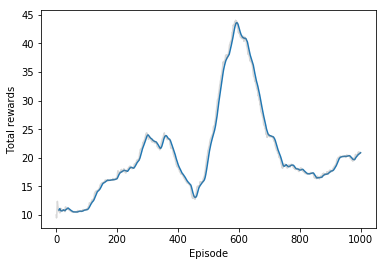

In [95]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

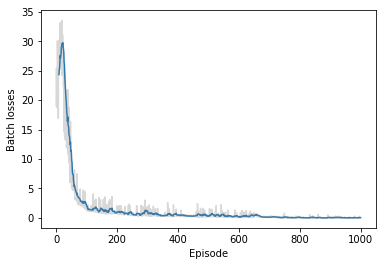

In [64]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.